### Mixed foraging and compartment model

broadly
- do equids as trial
    - range of equid body masses, fitness, prop grass

To do
- loop over strategies (done)
- loop over configurations (done)
- loop over body size (done)
- loop over environmental change (done)
    - between species and strats (done)
- store:
    - time survived (done)
    - compartment stats (done)
    - track proportions of grass/browse in compartments (done)
- implement traits
    - equids
        - velocity (done)
        - metabolism (done)
        - handling times
        - digestive times
    - grass/browse
- review g vs kg

Problems
- central problem is starvation never occurs. Need to iron out metabolic rates


Notes
- might be able to speed up by not regenerating distributions 


##### Current State of Variables
1) foraging strategies - Justin's 
2) alpha               - allometric
3) beta                - allometric
4) gamma               - allometric
5) resource gain       - 16.7 kj/g as in pure carb/protein
6) mouth size          - allometric
7) gut size            - allometric, gut type
8) fat max             - allometric
9) velocity            - allometric
10) metabolic rates    - allometric

In [27]:
using Distributed
using RCall
@everywhere using SharedArrays
@everywhere using Distributions
@everywhere using LinearAlgebra

include("./resource_functions.jl") # functions for the resource landscape
include("./consumer_functions.jl") # functions for the consumer dynamics
include("./intake_model_functions.jl") # functions for the consumer dynamics

    

find_nearest_resource (generic function with 2 methods)

In [28]:
using Random
Random.seed!(42);

In [29]:
number_resources = 2;
target_values = [0.0, 0.25, 0.5, 0.75, 1.0]; 
strategy_id = repeat(collect(1:number_resources), inner=(length(target_values), 1));
target_weight = repeat(target_values, outer=(number_resources, 1));
strategy_info = Tuple([strategy_id, target_weight]);


In [30]:
configurations = 1;

t = 0;   #[s]
t_max = 10000000; # 2629800s in a month

#species_list = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0];
species_list = [1000.0]
number_species = length(species_list);

#mouth = 0;
#mouth_max = 10;   #[g]

#gut = 11;
#gut_fill_max = 1000;  #[g]





#fat = 10;
#fat_max = 100000;   #[g]

#velocity = 1.0;   #[m/s]

at_food = false;
cropping = false;
chewing = false;

#alpha = [alpha_allo(mass, "graze"), alpha_allo(mass, "browse")#[1.0, 1.5]; # [g/s]
#beta = 1.0;         # [g/s]
#gamma = 0.01;        # [g/s]
#rates = [alpha, beta, gamma];

#basal = 0.001      #[kj/s]
#field = 0.01;     #[kj/s]

num_succ = 0;


# first pass RLB plant data suggested 0.1-0.3 kgC/m2yr
# experiment with monthly productivity as mean 8.3-25 g/m2month
resource_gain = [16.7, 16.7];


In [31]:
# grass, browse
# justify pure forest and pure grassland distrib
resource_scenarios = [
                     [[0.1 0.1]; [0.15 0.15]],
                     #[[0.2 24.0]; [0.25 30.0]],
                     #[[4.0 20.0];  [6.0  24.0]],
                     #[[8.0 16.0];  [10.0 20.0]],
                     #[[12.0 12.0]; [16.0 16.0]],
                     #[[16.0 8.0];  [20.0 12.0]],
                     #[[20.0 4.0];  [24.0 6.0]],
                     #[[24.0 0.1];  [30.0 0.15]]
    ];

number_scenarios = length(resource_scenarios)

1

In [32]:
# construct a vector of graze values for the figure legends
graze_vec = zeros(0)
for i in 1:number_scenarios
    append!(graze_vec, resource_scenarios[i,1][1])
end
graze_vec

1-element Array{Float64,1}:
 0.1

In [40]:
find_metabolism(1000)

(2.0e7, 0.5692099788303082, 1.4862705002791385, 2.626154e7)

In [43]:
20000000 - 1.4862705002791385 * 2629800

1.6091405838365922e7

In [33]:
# scenarios, data, species
species_data = zeros(Float64, number_scenarios, 6, length(strategy_id), number_species)

# loop through body masses
for species in 1:number_species
    strat_data = zeros(Float64, length(strategy_id), 6); # init array for storing data by config
    alpha = [alpha_allo(species_list[species], "graze"), 
        alpha_allo(species_list[species], "browse")]
    beta = beta_allo(species_list[species], "lophs and flat")

    mrt = mean_retention_time(species_list[species], "colon")
    #rates = [alpha, beta, gamma]
    
    
    mouth_max = bite_size_allo(species_list[species], "graze"); # [g]
    gut_fill_max = gut_volume_g(species_list[species], "colon")
    velocity = find_velocity(species_list[species]);
    initial_energy_state, basal, field, fat_max = find_metabolism(species_list[species]);
    costs = [basal, field];
    
    
for scenario in 1:length(resource_scenarios)
    resource_stats = resource_scenarios[scenario]
    
    
    
# loop through strategies
for target in 1:length(strategy_id)
    
config_data = zeros(Float64, configurations, 6); # init array for storing data by config

# loop through configurations
for config = 1:configurations  # loop from 1:10

#target=1;
t=0;
num_succ = [0,0];
at_food = false;
cropping = false;
chewing = false;

mouth = 0;  #[g]
gut = 100;   #[g]
fat = initial_energy_state;   #[g]
        
chosen_resource = 0;

###
#1 while there is time left in the day
while t <= t_max && fat >= 0

    gamma = outflow_rate(gut, mrt)
    #rates = [alpha, beta, gamma]
    ### ###
    #2 if you're hungry
    #if gut <= gut_fill_max && fat <= fat_max  
        
        # if you're not at some food
        if at_food == false;
            # selects a resource to go after
            #chosen_resource, distance = forage(strategy_id, target_weight, target, 
                #resource_stats);
            #travel_time = distance/velocity; 
            chosen_resource, travel_time = travel(strategy_id, target_weight, 
                            target, resource_stats, velocity, t, t_max)            
                        
            # move to the food
            mouth, gut, fat = update_compartments(travel_time, mouth, gut,
                fat, [alpha, beta, gamma], costs, resource_gain; travelling=true)
            t += travel_time;
            at_food = true;
                    
                if fat <= 0
                    break
                end
                    
        end
        
        ### ### ###
        #3 if mouth isn't full and you're not chewing and you're at some food
        if mouth < mouth_max &&  chewing == false && at_food == true  # crop some food
            handling_time = 1/alpha[chosen_resource]        
            mouth, gut, fat = update_compartments((1/handling_time), 
                mouth, gut, fat, [alpha, beta, gamma], costs, resource_gain; cropping=true, resource=chosen_resource)
            
            num_succ[chosen_resource] += 1
            t += handling_time
            at_food = false;
                    
                    if fat <= 0
                    break
                end
                    
        end
        
        # if you're mouth is full but not chewing
        if mouth >= mouth_max && chewing == false 
                    
                mouth = mouth_max;
                chewing = true # start chewing
        end
        
        
        if chewing == true && mouth > beta # if you are currently chewing   
            mouth, gut, fat = update_compartments((1/beta), mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain; chewing=true)
            t += (1/beta);
                    
                if fat <= 0
                    break
                end
                    
        end
        if chewing == true && mouth <= beta
                chewing = false
            
            end #3 end of if mouth isn't full and you're not chewing
        ### ### ###
                        
        #end #2 end of if you're not hungry
        ### ###    
        
                    
        # add note on why this was necessary
        mouth, gut, fat = update_compartments(1, mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain)
        
        #if fat <= 0
         #           break
          #      end
                
        t += 1.0;
            
    end  #1 end bout (while t<tmax_bout )
    ###
        
        
    config_data[config,1] = t;
    config_data[config,2] = num_succ[1];
    config_data[config,3] = num_succ[2];
    config_data[config,4] = mouth;
    config_data[config,5] = gut;
    config_data[config,6] = fat;
    
    end
# end loop through body configs
    #strat_data[target, 1] = mean(config_data)
    strat_data[target,1] = mean(config_data[:,1])
    strat_data[target,2] = mean(config_data[:,2])
    strat_data[target,3] = mean(config_data[:,3])
    strat_data[target,4] = mean(config_data[:,4])
    strat_data[target,5] = mean(config_data[:,5])
    strat_data[target,6] = mean(config_data[:,6])

    species_data[scenario,1,target, species] = strat_data[target,1]
    species_data[scenario,2,target, species] = strat_data[target,2]
    species_data[scenario,3,target, species] = strat_data[target,3]
    species_data[scenario,4,target, species] = strat_data[target,4]
    species_data[scenario,5,target, species] = strat_data[target,5]
    species_data[scenario,6,target, species] = strat_data[target,6]
            
    end # end loop through strategies
        
    
        
        
        end # end loop through resource scenarios

   
    

    end #loop through masses
# if [row, colum]

# time, graze, browse, mouth, gut, fat

In [34]:
# scenarios, data, strategies, species
# time, graze, browse, mouth, gut, fat
species_data

1×6×10×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0e7  220.0  262.0  0.530994  32.8428  5.13976e6

[:, :, 2, 1] =
 1.0e7  148.0  110.0  1.01092  9.83526  5.13849e6

[:, :, 3, 1] =
 1.0e7  205.0  60.0  1.49085  8.56815  5.13868e6

[:, :, 4, 1] =
 1.0e7  178.0  28.0  1.01092  17.0359  5.13843e6

[:, :, 5, 1] =
 1.0e7  181.0  0.0  0.530994  9.65233  5.13821e6

[:, :, 6, 1] =
 1.0e7  176.0  155.0  1.01092  36.7108  5.13926e6

[:, :, 7, 1] =
 1.0e7  50.0  64.0  1.01092  16.1295  5.13776e6

[:, :, 8, 1] =
 1.0e7  52.0  165.0  1.01092  21.2639  5.13861e6

[:, :, 9, 1] =
 1.0e7  31.0  161.0  0.530994  40.7178  5.13832e6

[:, :, 10, 1] =
 1.0e7  0.0  100.0  0.530994  30.6956  5.13768e6

In [35]:
plotting_data = zeros(Float64, number_scenarios, 3, number_species); 

for scene in 1:number_scenarios
    for datum in 1:3
        for species in 1:number_species
            
            plotting_data[scene,datum,species]=mean(species_data[scene,datum,:,species])
            
        end
    end
end
# scenarios, data, species
plotting_data

1×3×1 Array{Float64,3}:
[:, :, 1] =
 1.0e7  124.1  110.5

In [36]:
# make plotting data into three matrices (fitness, graze, browse)

fitness_data = zeros(Float64, number_scenarios, number_species,); 
graze_data = zeros(Float64, number_scenarios, number_species,); 
browse_data = zeros(Float64, number_scenarios, number_species,); 


for scene in 1:number_scenarios
    for species in 1:number_species
            
        fitness_data[scene ,species]=plotting_data[scene, 1, species]
        graze_data[scene ,species]=plotting_data[scene, 2, species]
        browse_data[scene ,species]=plotting_data[scene, 3, species]

    end
end

fitness_data

1×1 Array{Float64,2}:
 1.0000002410262354e7

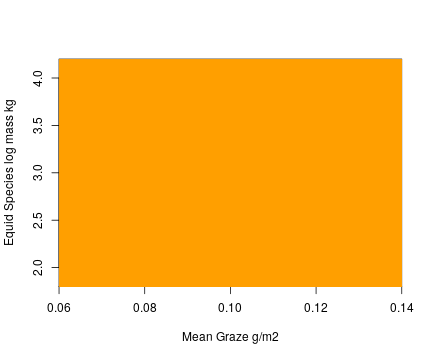

RObject{NilSxp}
NULL


In [37]:
# time survived
R"""

library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")

image(y=log10($(species_list)),x=c($graze_vec) , z=$(fitness_data), ylab="Equid Species log mass kg", 
        xlab="Mean Graze g/m2")
"""

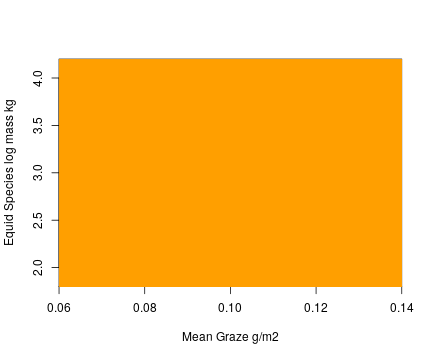

RObject{NilSxp}
NULL


In [38]:
# graze in diet
R"""

library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")

image(y=log10($(species_list)),x=c($graze_vec), z=$(graze_data), ylab="Equid Species log mass kg", 
        xlab="Mean Graze g/m2")
"""

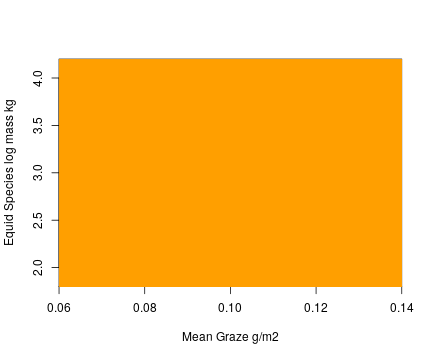

RObject{NilSxp}
NULL


In [39]:
# browse in diet
#y=c(graze_vec)
R"""
library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")
image(y=log10($(species_list)), x=c($graze_vec) , z=$(browse_data), ylab="Equid Species log mass kg", 
        xlab="Mean Graze g/m2")
"""